# Introduction

We have explored creating neural networks from scratch, we will now use libraries like fastai and pytorch for doing the same. Benefits of using these libraries include:
* Best practices/ settings are handled automatically.
* It takes less time setting up.
* We can dropdown or convert from one library to another or into simple python codes for deeper customizations.

We'll import the fastai tabular library, set a random seed so the notebook is reproducible, and pick a reasonable number of significant figures to display in our tables:

In [1]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [2]:
train = pd.read_csv("playground-series-s5e5/train.csv")
test = pd.read_csv("playground-series-s5e5/test.csv")

In [3]:
train.columns

Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories'],
      dtype='object')

In [4]:
test.columns

Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp'],
      dtype='object')

In [5]:
df = train.copy()
df.columns

Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories'],
      dtype='object')

In [6]:
df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.00,82.00,26.00,101.00,41.00,150.00
1,1,female,64,163.00,60.00,8.00,85.00,39.70,34.00
2,2,female,51,161.00,64.00,7.00,84.00,39.80,29.00
3,3,male,20,192.00,90.00,25.00,105.00,40.70,140.00
4,4,female,38,166.00,61.00,25.00,102.00,40.60,146.00


Check if there are any duplicate rows for predictions in the dataset.

In [7]:
df.drop(columns=['id']).duplicated().value_counts()

False    747159
True       2841
Name: count, dtype: int64

In [8]:
df = df[~df.drop(columns=['id']).duplicated()].reset_index(drop=True)

# Preparing the Data
While doing every bit of feature engineering from scratch, we need to take care of things like dummy variables, normalization, missing values, and so on. But fastai takes care of these.

In [9]:
def create_predictor_features(df):
    df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)
    df['Intensity'] = df['Heart_Rate'] * df['Duration']
    df['Age_Group'] = pd.cut(
        df['Age'],
        bins=[0, 20, 35, 50, 65, 100],
        labels=['Teen', 'Young Adult', 'Adult', 'Middle Age', 'Senior']
    )
    df['Temp_Above_Normal'] = df['Body_Temp'] - 37.0
    def heart_rate_zone(hr):
        if hr < 90:
            return 'Low'
        elif hr < 120:
            return 'Moderate'
        else:
            return 'High'
    df['HR_Zone'] = df['Heart_Rate'].apply(heart_rate_zone)
    return df

df_train = create_predictor_features(df)

In [10]:
numerical_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

def add_feature_cross_terms(df, numerical_features):
    df_new = df.copy()
    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
    return df_new

df_train = add_feature_cross_terms(df_train, numerical_features)

In [11]:
df.columns

Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories', 'BMI', 'Intensity', 'Age_Group',
       'Temp_Above_Normal', 'HR_Zone'],
      dtype='object')

In [12]:
df_train.columns

Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories', 'BMI', 'Intensity', 'Age_Group',
       'Temp_Above_Normal', 'HR_Zone', 'Age_x_Height', 'Age_x_Weight',
       'Age_x_Duration', 'Age_x_Heart_Rate', 'Age_x_Body_Temp',
       'Height_x_Weight', 'Height_x_Duration', 'Height_x_Heart_Rate',
       'Height_x_Body_Temp', 'Weight_x_Duration', 'Weight_x_Heart_Rate',
       'Weight_x_Body_Temp', 'Duration_x_Heart_Rate', 'Duration_x_Body_Temp',
       'Heart_Rate_x_Body_Temp'],
      dtype='object')

In [13]:
df_train["y_train"] = np.log1p( df_train["Calories"])

Now entire process of getting the data ready for training requires just one cell:

In [14]:
cat_names = ['Sex', 'Age_Group', 'HR_Zone']
cont_names = ['BMI', 'Intensity', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp',
       'Temp_Above_Normal', 'Age_x_Height', 'Age_x_Weight',
       'Age_x_Duration', 'Age_x_Heart_Rate', 'Age_x_Body_Temp',
       'Height_x_Weight', 'Height_x_Duration', 'Height_x_Heart_Rate',
       'Height_x_Body_Temp', 'Weight_x_Duration', 'Weight_x_Heart_Rate',
       'Weight_x_Body_Temp', 'Duration_x_Heart_Rate', 'Duration_x_Body_Temp',
       'Heart_Rate_x_Body_Temp']

In [15]:
splits = RandomSplitter(seed = 42)(df_train)

In [16]:
dls = TabularPandas(
    df_train, splits = splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names = cat_names,
    cont_names = cont_names,
    y_names = "y_train", y_block = RegressionBlock(),
).dataloaders(path=".")

Here's what each of the parameters means:
* Use splits for indices of training and validation sets:
  ```
  splits = splits,
  ```
* Turn strings into categories, fill missing values in numeric columns with the median, normalise all numeric columns:
* ```
  procs = [Categorify, FillMissing, Normalize],
  ```
* These are the categorical independent variables:
  ```
  cat_names = ['Sex'],
  ```
* These are the continuous independent variables:
  ```
  cont_names = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'],
  ```
* This is the dependent variable:
  ```
  y_names = "Calories",
  ```
* The dependent variable is a regression model:
  ```
  y_block = RegressionBlock(),
  ```

In [17]:
dls.xs.iloc[:2]

,Sex,Age_Group,HR_Zone,BMI,Intensity,Age,Height,Weight,Duration,Heart_Rate,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
317208,2,3,3,0.04,0.22,0.37,-0.05,-0.08,0.19,0.79,...,-0.12,0.18,0.61,0.03,0.15,0.29,-0.05,0.22,0.18,0.74
88983,1,5,2,-1.12,-0.80,2.41,-0.83,-1.01,-0.77,-0.69,...,-0.97,-0.83,-1.02,-0.95,-0.90,-1.15,-1.06,-0.80,-0.78,-0.70


In [18]:
dls.show_batch()

,Sex,Age_Group,HR_Zone,BMI,Intensity,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Temp_Above_Normal,Age_x_Height,Age_x_Weight,Age_x_Duration,Age_x_Heart_Rate,Age_x_Body_Temp,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp,y_train
0,female,Young Adult,Moderate,23.53,368.00,23.00,161.00,61.00,4.00,92.00,38.90,1.90,3703.00,1403.00,92.00,2116.00,894.70,9821.00,644.00,14812.00,6262.90,244.00,5612.00,2372.90,368.00,155.60,3578.80,2.94
1,male,Senior,Moderate,28.01,1767.00,69.00,188.00,99.00,19.00,93.00,40.70,3.70,12972.00,6831.00,1311.00,6417.00,2808.30,18612.00,3572.00,17484.00,7651.60,1881.00,9207.00,4029.30,1767.00,773.30,3785.10,4.81
2,female,Adult,Moderate,22.68,1615.00,50.00,164.00,61.00,17.00,95.00,40.10,3.10,8200.00,3050.00,850.00,4750.00,2005.00,10004.00,2788.00,15580.00,6576.40,1037.00,5795.00,2446.10,1615.00,681.70,3809.50,4.52
3,male,Middle Age,Low,25.42,240.00,61.00,185.00,87.00,3.00,80.00,38.70,1.70,11285.00,5307.00,183.00,4880.00,2360.70,16095.00,555.00,14800.00,7159.50,261.00,6960.00,3366.90,240.00,116.10,3096.00,2.48
4,male,Adult,Moderate,24.98,3540.00,45.00,194.00,94.00,30.00,118.00,41.20,4.20,8730.00,4230.00,1350.00,5310.00,1854.00,18236.00,5820.00,22892.00,7992.80,2820.00,11092.00,3872.80,3540.00,1236.00,4861.60,5.57
5,male,Middle Age,Moderate,26.88,1302.00,54.00,184.00,91.00,14.00,93.00,40.00,3.00,9936.00,4914.00,756.00,5022.00,2160.00,16744.00,2576.00,17112.00,7360.00,1274.00,8463.00,3640.00,1302.00,560.00,3720.00,4.34
6,female,Young Adult,Low,22.55,1157.00,33.00,159.00,57.00,13.00,89.00,39.80,2.80,5247.00,1881.00,429.00,2937.00,1313.40,9063.00,2067.00,14151.00,6328.20,741.00,5073.00,2268.60,1157.00,517.40,3542.20,4.01
7,male,Adult,Moderate,24.40,2940.00,38.00,191.00,89.00,28.00,105.00,41.10,4.10,7258.00,3382.00,1064.00,3990.00,1561.80,16999.00,5348.00,20055.00,7850.10,2492.00,9345.00,3657.90,2940.00,1150.80,4315.50,5.20
8,male,Young Adult,Moderate,25.18,184.00,32.00,176.00,78.00,2.00,92.00,38.20,1.20,5632.00,2496.00,64.00,2944.00,1222.40,13728.00,352.00,16192.00,6723.20,156.00,7176.00,2979.60,184.00,76.40,3514.40,2.20
9,male,Senior,Moderate,25.03,3360.00,75.00,181.00,82.00,30.00,112.00,41.00,4.00,13575.00,6150.00,2250.00,8400.00,3075.00,14842.00,5430.00,20272.00,7421.00,2460.00,9184.00,3362.00,3360.00,1230.00,4592.00,5.56


# Train the model

The data and model together make up a Learner. To set it up, we specify the data (dls) and the size of each hidden layer ([100, 200, 100]), along with any metrics we like to monitor during training such as absolute error, rmsle, etc. We do not need to initialize a set of random coefficients that will train correctly as it will be done automatically. 

We can also find what learning rate is good using fastai.

In [19]:
learn = tabular_learner(dls, metrics=mse, layers=[100, 200, 100])

SuggestedLRs(slide=0.00019054606673307717, valley=0.0030199517495930195)

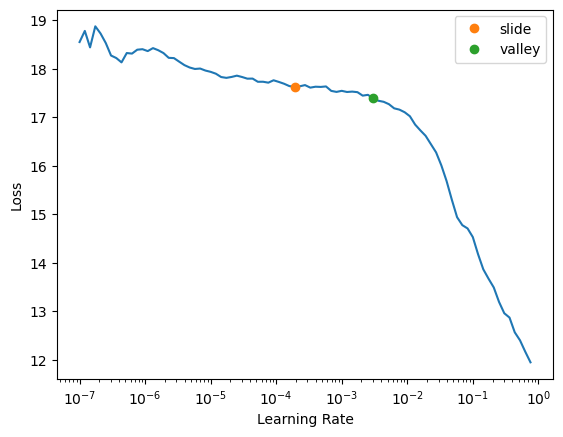

In [20]:
learn.lr_find(suggest_funcs=(slide, valley))

In [21]:
learn.fit_one_cycle(3, 0.0025)

epoch,train_loss,valid_loss,mse,time
0,0.026448,0.010492,0.010492,00:46
1,0.027051,0.008045,0.008045,00:45
2,0.016242,0.006868,0.006868,00:47


In [22]:
learn.show_results()

,Sex,Age_Group,HR_Zone,BMI,Intensity,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Temp_Above_Normal,Age_x_Height,Age_x_Weight,Age_x_Duration,Age_x_Heart_Rate,Age_x_Body_Temp,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp,y_train,y_train_pred
0,1.00,2.00,3.00,-1.25,0.47,-1.08,-0.37,-0.73,0.55,0.37,0.46,0.47,-1.10,-1.13,-0.32,-0.97,-1.06,-0.66,0.48,0.07,-0.24,0.21,-0.49,-0.68,0.47,0.54,0.39,4.63,4.62
1,2.00,5.00,3.00,1.19,1.50,1.69,0.18,0.49,1.51,1.01,1.11,1.11,1.70,1.77,2.79,2.03,1.78,0.36,1.54,0.93,0.47,1.69,0.95,0.62,1.50,1.52,1.06,5.35,5.31
2,2.00,4.00,2.00,1.63,-1.00,0.83,1.51,1.85,-1.01,-0.90,-0.69,-0.69,1.19,1.74,-0.59,0.49,0.78,1.85,-0.91,0.10,1.27,-0.67,1.06,1.75,-1.00,-1.01,-0.90,3.50,3.52
3,1.00,3.00,2.00,-0.88,-1.39,-0.09,-1.15,-1.15,-1.49,-1.43,-2.35,-2.36,-0.31,-0.58,-1.18,-0.45,-0.21,-1.13,-1.50,-1.74,-1.67,-1.46,-1.54,-1.34,-1.39,-1.48,-1.59,2.48,2.56
4,2.00,4.00,3.00,-0.61,-0.37,1.49,0.96,0.49,-0.29,-0.37,0.08,0.08,1.75,1.59,0.43,1.27,1.49,0.60,-0.18,0.26,0.96,-0.14,0.24,0.50,-0.37,-0.30,-0.32,4.32,4.25
5,1.00,2.00,3.00,0.36,0.86,-1.35,-0.83,-0.58,0.91,0.69,0.85,0.85,-1.40,-1.29,-0.36,-1.19,-1.32,-0.68,0.73,0.02,-0.61,0.57,-0.22,-0.50,0.86,0.91,0.74,4.83,4.79
6,2.00,1.00,3.00,0.04,1.10,-1.41,-0.05,-0.08,1.03,1.22,0.98,0.98,-1.39,-1.24,-0.36,-1.20,-1.38,-0.12,1.01,0.95,0.20,0.92,0.49,0.02,1.10,1.03,1.23,4.92,4.84
7,1.00,3.00,3.00,-0.64,1.30,0.24,0.34,-0.01,1.27,1.11,1.49,1.49,0.30,0.19,1.20,0.54,0.32,0.04,1.33,1.12,0.72,1.18,0.51,0.15,1.30,1.30,1.23,5.12,5.02
8,2.00,5.00,3.00,0.31,1.72,1.88,0.80,0.71,1.74,1.01,1.36,1.36,2.11,2.12,3.30,2.23,2.00,0.71,1.94,1.34,1.16,2.07,1.15,0.86,1.72,1.77,1.11,5.51,5.40


In [23]:
preds_train, targets_train = learn.get_preds(dl=dls.train)

In [24]:
for i in range(15):
    row = dls.valid_ds.items.iloc[i].copy()  # make an explicit copy
    pred_val = preds_train[i].item()
    row['Calories'] = pred_val
    decoded_row = dls.train.decode_row(row)
    
    actual_row = dls.train.decode_row(dls.valid_ds.items.iloc[i])
    print(f"Predicted: {decoded_row['y_train']:.6f}, Actual: {actual_row['y_train']:.6f}")


Predicted: 1.386294, Actual: 1.386294
Predicted: 4.110874, Actual: 4.110874
Predicted: 5.267858, Actual: 5.267858
Predicted: 4.356709, Actual: 4.356709
Predicted: 5.056246, Actual: 5.056246
Predicted: 4.488636, Actual: 4.488636
Predicted: 3.295837, Actual: 3.295837
Predicted: 4.418840, Actual: 4.418840
Predicted: 3.850147, Actual: 3.850147
Predicted: 3.367296, Actual: 3.367296
Predicted: 5.192957, Actual: 5.192957
Predicted: 4.110874, Actual: 4.110874
Predicted: 4.672829, Actual: 4.672829
Predicted: 4.382027, Actual: 4.382027
Predicted: 4.007333, Actual: 4.007333


In [25]:
test_df = test.copy()

In [26]:
test_df = create_predictor_features(test_df)
test_df = add_feature_cross_terms(test_df, numerical_features)

In [27]:
dl = learn.dls.test_dl(test_df)

In [28]:
preds = learn.get_preds(dl=dl)

In [29]:
final_preds = np.expm1(preds[0])
final_preds.min(), final_preds.max()

(tensor(1.0727), tensor(292.3135))

In [30]:
final_preds = np.clip(final_preds, df_train["Calories"].min(), df_train["Calories"].max())  

final_preds.min(), final_preds.max()

(tensor(1.0727), tensor(292.3135))

In [31]:
test_df['Calories'] = final_preds
sub_df = test_df[['id','Calories']]

In [32]:
test_df['Calories'] 

0         28.09
1        103.41
2         82.09
3        119.19
4         73.37
          ...  
249995    26.87
249996     9.86
249997    71.24
249998   157.08
249999    74.55
Name: Calories, Length: 250000, dtype: float32

In [33]:
sub_df.to_csv('subm.csv', index=False)

# Ensembling

We can create five separate models, each trained from different random starting points, and average them. This is the simplest approach of ensembling models, which combines multiple models to generate predictions that are better than any of the single models in the ensemble.

In [36]:
def ensemble():
    learn = tabular_learner(dls, metrics=mse, layers=[100, 200, 100])
    with learn.no_bar(),learn.no_logging(): learn.fit_one_cycle(3, 0.0025)
    print("---------------------ensemble---------------------")
    return learn.get_preds(dl=dl)[0]

Now we run this five times, and collect the results into a list:

In [37]:
learns = [ensemble() for _ in range(5)]

---------------------ensemble---------------------


---------------------ensemble---------------------


---------------------ensemble---------------------


---------------------ensemble---------------------


---------------------ensemble---------------------


We stack this predictions together and take their average predictions:

In [38]:
ens_preds = torch.stack(learns).mean(0)

In [40]:
final_ens_preds = np.expm1(ens_preds)
final_ens_preds.min(), final_ens_preds.max()

(tensor(1.1106), tensor(289.5667))

In [39]:
ens_preds

tensor([[3.3517],
        [4.6343],
        [4.4227],
        ...,
        [4.2637],
        [5.0617],
        [4.3072]])

In [41]:
final_ens_preds = np.clip(final_ens_preds, df_train["Calories"].min(), df_train["Calories"].max())  

final_ens_preds.min(), final_ens_preds.max()

(tensor(1.1106), tensor(289.5667))

In [43]:
test_df['Calories'] = final_ens_preds
sub_df = test_df[['id','Calories']]
test_df['Calories'] 

0         27.55
1        101.95
2         82.32
3        117.84
4         72.79
          ...  
249995    26.55
249996    10.04
249997    70.07
249998   156.86
249999    73.23
Name: Calories, Length: 250000, dtype: float32

In [44]:
sub_df.to_csv('ensemble.csv', index=False)

Public Score: 0.0693 